# Assignment 2 / Author Profiling -- Gender and Age

In [1]:
import nltk
import csv
import itertools
from scipy.sparse import dok_matrix
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
from nltk.stem import PorterStemmer

## Daten einlesen

In [2]:
messages = pd.read_csv('Messages_train.csv', sep=',')

In [3]:
messages.head()

,id,text,person_gender,person_age
0,117808,The particular DKNY bags are among the leading...,male,20s
1,5634,Dental implants are posts made of titanium tha...,female,30s
2,94820,"<p style=""text-align:center;]<a href=""http://e...",female,20s
3,64510,The primary business I joined was the Gospel N...,male,20s
4,89288,Taking QR Codes to Another Level<br />QR Codes...,female,30s


## Cleaning Data

In [4]:
df = pd.DataFrame(messages, columns = ['id', 'text', 'person_gender', 'person_age'])
df = df.drop(df[(df.person_gender != "male") & (df.person_gender != "female")].index)
df = df.drop(df[(df.person_age != "10s") & (df.person_age != "20s") & (df.person_age != "30s")].index)


## Test / Dev / Train Split

In [5]:
generated_train_set, generated_test_set = train_test_split(df, test_size=0.2,)

test_df = pd.DataFrame(generated_test_set, columns = ['id', 'text', 'person_gender', 'person_age'])
test_df = test_df.drop(test_df[(test_df.person_gender != "male") & (test_df.person_gender != "female")].index)
test_df = test_df.drop(test_df[(test_df.person_age != "10s") & (test_df.person_age != "20s") & (test_df.person_age != "30s")].index)
test_df.to_csv('test.csv', index=False)

## Testdatei einlesen

In [6]:
#Hier die Testdatei einlesen:
#-------------------------------------------
test_set = pd.read_csv('test.csv', sep=',')
#-------------------------------------------

In [7]:
train_set = generated_train_set
train_set = train_set.astype(dtype='<U6')

Y_train_gender = train_set['person_gender'].values
Y_test_gender = test_set['person_gender'].values
Y_test_gender = Y_test_gender.astype(dtype='<U6')

Y_train_age = train_set['person_age'].values
Y_test_age = test_set['person_age'].values
Y_test_age = Y_test_age.astype(dtype='<U6')

Y_train_combo = train_set['person_gender'] + '' + train_set['person_age']
Y_test_combo = test_set['person_gender'] + '' + test_set['person_age']
Y_test_combo = Y_test_combo.astype(dtype='<U6')

print('train set: ', len(train_set))
print('test set: ', len(test_set)) 

train set:  80000
test set:  20000


## Cleaning Training Set

In [8]:
train_df = pd.DataFrame(generated_train_set, columns = ['id', 'text', 'person_gender', 'person_age'])
train_df.text = train_df.text.str.replace('<[^<]+?>', '')
train_df['text'] = train_df['text'].str.replace('\d+', '')
train_df['text'] = train_df['text'].str.replace('[^\w\s]', '')

## Vectorizer
Prozesse wie Lemmatisieren, Stemming und entfernen von Stopwörtern wurden bewusst weggelassen, da sich diese Operationen negativ auf die Genauigkeit so wie auch Performance ausgewirkt hatten.
#### Warnung: dieser Schritt dauert 5-15min, je nach Rechnerleistung!

In [9]:
vectorizer = CountVectorizer(#LemmaTokenizer(),
                             #stop_words='english'
                             lowercase=True, 
                             ngram_range=(4,4),
                             analyzer = "word"
                            )
X_train_counts = vectorizer.fit_transform(train_set['text'].values)
X_test_counts = vectorizer.transform(test_set['text'].values)


#Tokenizer aufbereitet für den Countvectorizer, falls benötigt:
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, articles):
        return [self.wnl.lemmatize(t) for t in word_tokenize(articles)]
    
class StemmerTokenizer(object):
    def __init__(self):
        self.wnl = PorterStemmer()
    def __call__(self, articles):
        return [self.wnl.stem(t) for t in word_tokenize(articles)]

## Transformer

In [10]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)

## Classifiers

In [11]:
classifier_NB_gender = OneVsRestClassifier(MultinomialNB(fit_prior=True, class_prior=None)).fit(X_train_tfidf, Y_train_gender)
classifier_NB_age = OneVsRestClassifier(MultinomialNB(fit_prior=False)).fit(X_train_tfidf, Y_train_age)
classifier_NB_combo = MultinomialNB(fit_prior=False).fit(X_train_tfidf, Y_train_combo)

## Classify

In [12]:
predicted_gender = classifier_NB_gender.predict(X_test_tfidf)
accuracy_gender = accuracy_score(Y_test_gender, predicted_gender)

predicted_age = classifier_NB_age.predict(X_test_tfidf)
accuracy_age = accuracy_score(Y_test_age, predicted_age)

predicted_combo = classifier_NB_combo.predict(X_test_tfidf)
accuracy_combo = accuracy_score(Y_test_combo, predicted_combo)

## Confusion Matrix

In [13]:
def plot_confusion_matrix_(cm, classes, title = 'Confusion matrix', cmap = plt.cm.Blues):
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)

    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm_norm[np.isnan(cm_norm)] = 0
    cm_norm = np.around(cm_norm, decimals = 3)
        
    plt.imshow(cm_norm, interpolation='nearest', cmap = cmap)
    
    thresh = cm_norm.max() / 2.
    for i, j in itertools.product(range(cm_norm.shape[0]), range(cm_norm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="black" if cm_norm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

## Auswertung

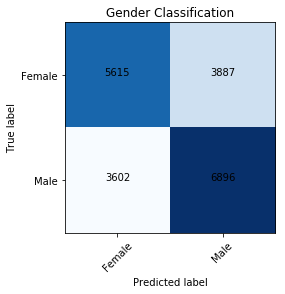

Accuracy:  0.62555
              precision    recall  f1-score   support

      female       0.61      0.59      0.60      9502
        male       0.64      0.66      0.65     10498

   micro avg       0.63      0.63      0.63     20000
   macro avg       0.62      0.62      0.62     20000
weighted avg       0.63      0.63      0.63     20000

---------------------------------------------------------------------


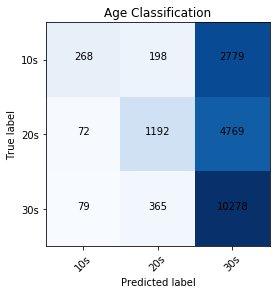

Accuracy:  0.5869
              precision    recall  f1-score   support

         10s       0.64      0.08      0.15      3245
         20s       0.68      0.20      0.31      6033
         30s       0.58      0.96      0.72     10722

   micro avg       0.59      0.59      0.59     20000
   macro avg       0.63      0.41      0.39     20000
weighted avg       0.62      0.59      0.50     20000

---------------------------------------------------------------------


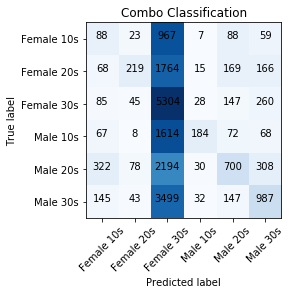

Accuracy:  0.3741
              precision    recall  f1-score   support

   female10s       0.11      0.07      0.09      1232
   female20s       0.53      0.09      0.16      2401
   female30s       0.35      0.90      0.50      5869
     male10s       0.62      0.09      0.16      2013
     male20s       0.53      0.19      0.28      3632
     male30s       0.53      0.20      0.29      4853

   micro avg       0.37      0.37      0.37     20000
   macro avg       0.45      0.26      0.25     20000
weighted avg       0.46      0.37      0.31     20000



In [14]:
cm_gender = confusion_matrix(Y_test_gender, predicted_gender)
plot_confusion_matrix_(cm_gender, ['Female', 'Male'], title = 'Gender Classification')
print('Accuracy: ', accuracy_gender)
print(classification_report(Y_test_gender, predicted_gender))
print('---------------------------------------------------------------------')

cm_age = confusion_matrix(Y_test_age, predicted_age)
plot_confusion_matrix_(cm_age, ['10s', '20s', '30s'], title = 'Age Classification')
print('Accuracy: ', accuracy_age)
print(classification_report(Y_test_age, predicted_age))
print('---------------------------------------------------------------------')

cm_combo = confusion_matrix(Y_test_combo, predicted_combo)
plot_confusion_matrix_(cm_combo, ['Female 10s', 'Female 20s', 'Female 30s', 'Male 10s', 'Male 20s', 'Male 30s'], title = 'Combo Classification')
print('Accuracy: ', accuracy_combo)
print(classification_report(Y_test_combo, predicted_combo))